# SLU14: Model complexity and overfitting - Examples

In this notebook we will be covering the following

- Single Factor Analysis
- Feature Importance
- Regularization
- Unbalanced data

In [1]:
# all imports at the top!
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (
    SelectFromModel, 
    SelectKBest, 
    mutual_info_classif,
    chi2,
    f_classif
)
from sklearn.model_selection import learning_curve

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from utils import plot_classification


In [2]:
df = pd.read_csv('data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Single Factor Analysis on Categoricals



## nunique

count how many unique values exist for a categorical

In [3]:
df.Ticket.nunique()

681

In [4]:
df.PassengerId.nunique()

891

## value_counts

count the occurrences of each category for a feature

In [5]:
df.Ticket.value_counts().head()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
Name: Ticket, dtype: int64

In [6]:
df.Cabin.value_counts().head()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
Name: Cabin, dtype: int64

## plot the value counts for all categoricals

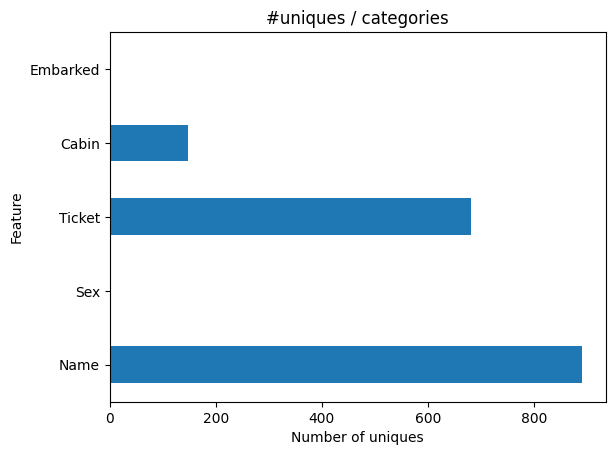

In [7]:
categorical_columns = df.select_dtypes(include='object').columns
pd.Series({
    colname: df[colname].nunique()
    for colname in categorical_columns
}, index=categorical_columns).plot.barh();
plt.xlabel('Number of uniques');
plt.ylabel('Feature');
plt.title("#uniques / categories");

# Feature importance

Using any tree-based estimator, you can get feature importances on a model that has already been fitted

In [8]:
# and this is how we used it

X = df.select_dtypes(exclude='object').fillna(-1).drop('Survived', axis=1)
y = df.Survived

clf = DecisionTreeClassifier(random_state=1, max_depth=5)

In [9]:
# model must be fitted
clf.fit(X, y)
feature_importances = clf.feature_importances_

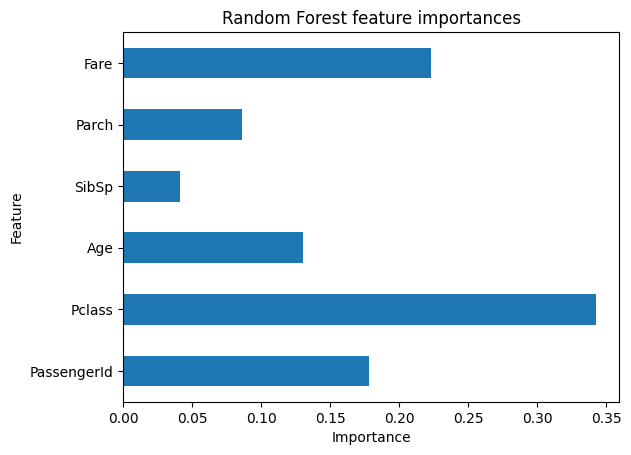

In [10]:
# now you can plot the importances by creating a pandas Series with the correct index

pd.Series(clf.feature_importances_, index=X.columns).plot.barh(title='feature importances');
plt.title('Random Forest feature importances')
plt.xlabel('Importance');
plt.ylabel('Feature');

# Logistic Regression coefficient

Using linear models that fit coefficients

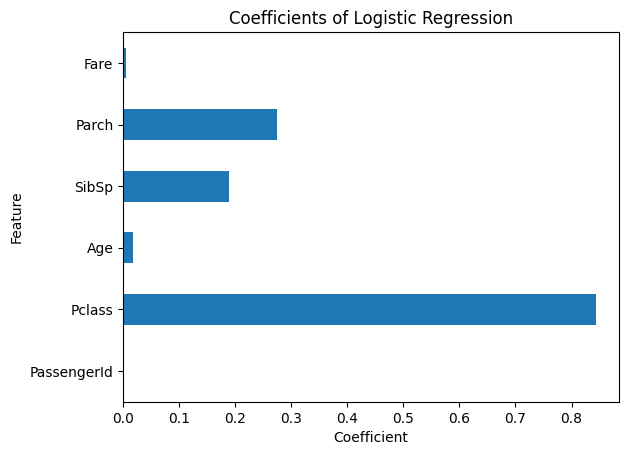

In [13]:
clf = LogisticRegression(random_state=1, solver='lbfgs', max_iter=2000)
clf.fit(X, y)
abs_coefs = pd.Series(clf.coef_[0, :], index=X.columns).abs()
abs_coefs.plot.barh();
plt.title('Coefficients of Logistic Regression')
plt.xlabel('Coefficient');
plt.ylabel('Feature');

## Correlations

Computing correlations is pure pandas. 

In [14]:
X.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.035144,0.037997,-0.057527,-0.001652,0.012658
Pclass,-0.035144,1.000000,-0.359728,0.083081,0.018443,-0.549500
Age,0.037997,-0.359728,1.000000,-0.182282,-0.045272,0.135707
SibSp,-0.057527,0.083081,-0.182282,1.000000,0.414838,0.159651
Parch,-0.001652,0.018443,-0.045272,0.414838,1.000000,0.216225
Fare,0.012658,-0.549500,0.135707,0.159651,0.216225,1.000000


## SelectFromModel

Using a previously trained model that is either a linear or tree-based model, we can select use SelectFromModel to select the top k features without having to know which type it is.

In [16]:
clf_linear = LogisticRegression(random_state=1, solver='lbfgs', max_iter=2000)
clf_linear.fit(X, y);

In [17]:
clf_tree = DecisionTreeClassifier(random_state=1, max_depth=5)
clf_tree.fit(X, y);

In [18]:
def select_from_model(clf, X_train):
    sfm = SelectFromModel(clf, prefit=True, max_features=4)
    selected_features = X_train.columns[sfm.get_support()]
    return list(selected_features)

In [19]:
select_from_model(clf_linear, X)

['Pclass', 'Parch']

In [20]:
select_from_model(clf_tree, X)

['PassengerId', 'Pclass', 'Fare']

## SelectKBest

Using functions that take measures between individual features and the target column, you can also select the k with the highest scores

In [21]:
def select_k_best(method, X, y, k=4):
    skb = SelectKBest(method, k=k)
    skb.fit(X, y)
    if method is not mutual_info_classif:
        p_values = skb.pvalues_.round(4)
    else:
        p_values = None
    result = pd.DataFrame({
        'column': X.columns, 
        'p_values': p_values, 
        'scores': skb.scores_,
        'selected': skb.get_support()
    }).sort_values(by='scores', ascending=False)
    return result

In [22]:
select_k_best(mutual_info_classif, X, y)

,column,p_values,scores,selected
5,Fare,None,0.125642,True
1,Pclass,None,0.066068,True
0,PassengerId,None,0.015798,True
3,SibSp,None,0.014941,True
4,Parch,None,0.004235,False
2,Age,None,0.003692,False


In [23]:
# chi2 cannot handle negative numbers so quick hack to make them all positive
# DON'T DO THIS BLINDLY! THIS IS JUST A HACK FOR DEMONSTRATION PURPOSES!
select_k_best(chi2, X.abs(), y)

,column,p_values,scores,selected
5,Fare,0.0000,4518.319091,True
1,Pclass,0.0000,30.873699,True
4,Parch,0.0015,10.097499,True
0,PassengerId,0.0687,3.312934,True
3,SibSp,0.1081,2.581865,False
2,Age,0.3654,0.819417,False


In [24]:
select_k_best(f_classif, X, y)

,column,p_values,scores,selected
1,Pclass,0.0000,115.031272,True
5,Fare,0.0000,63.030764,True
4,Parch,0.0148,5.963464,True
3,SibSp,0.2922,1.110572,True
2,Age,0.7108,0.137576,False
0,PassengerId,0.8814,0.022285,False


# Regularized Linear Regression


In [30]:
from utils import create_dataset, expand_dataset, L2Normalizer

In [31]:
# Create dummy dataset
data = create_dataset()
original_data = data.copy()
data.head(2)

,x,y
0,0.000000,0.138614
1,0.017453,0.078850


## Ridge Regression

#### Loss function (add $L_2$ norm to Mean Squared Error):

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_2 \sum_{k=1}^K \beta_k^2$$


In [32]:
data = expand_dataset(original_data, 10)

X = data.drop('y', axis=1)
y = data['y']

In [33]:
data.head(2)

,x,y,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9
0,0.000000,0.138614,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.017453,0.078850,0.000305,0.000005,9.279177e-08,1.619522e-09,2.826599e-11,4.933346e-13,8.610313e-15,1.502783e-16


In [34]:
from sklearn.linear_model import Ridge

In [35]:
ridge = Ridge(alpha=0.0001, random_state=10)
ridge.fit(L2Normalizer(X), y)

Ridge(alpha=0.0001, random_state=10)

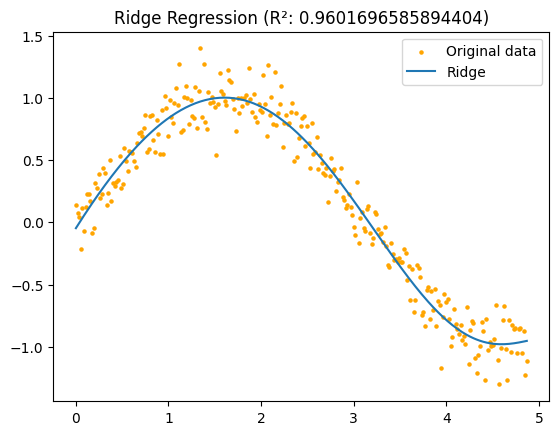

In [36]:
plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], ridge.predict(L2Normalizer(X)), label="Ridge")
plt.title('Ridge Regression (R²: {})'.format(ridge.score(L2Normalizer(X), y)));
plt.legend(loc="best")

    
## Lasso Regression

#### Loss function (add $L_1$ norm to Mean Squared Error):

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right|$$


In [39]:
from sklearn.linear_model import Lasso

In [41]:
lasso = Lasso(alpha=0.0002, random_state=10, max_iter=4000, tol=0.005)
lasso.fit(L2Normalizer(X), y)

Lasso(alpha=0.0002, max_iter=4000, random_state=10, tol=0.005)

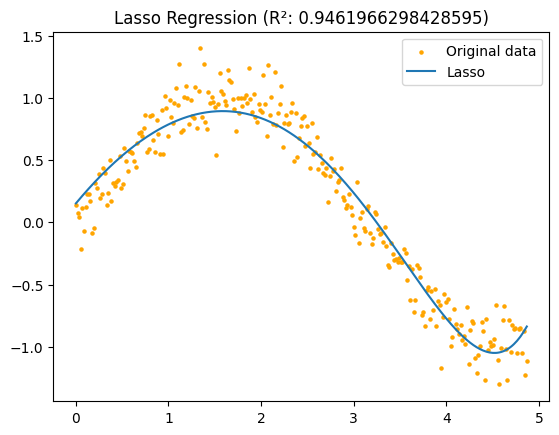

In [42]:
plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], lasso.predict(L2Normalizer(X)), label="Lasso")
plt.title('Lasso Regression (R²: {})'.format(lasso.score(L2Normalizer(X), y)));
plt.legend(loc="best")


## Elastic Net Regression

#### Loss function (add $L_1$ and $L_2$ norms to Mean Squared Error):

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right| + \lambda_2 \sum_{k=1}^K \beta_k^2$$


In [45]:
from sklearn.linear_model import ElasticNet

In [46]:
en = ElasticNet(alpha=0.00001, l1_ratio=0.5, random_state=10, max_iter=5000, tol=0.005)
en.fit(L2Normalizer(X), y)

ElasticNet(alpha=1e-05, max_iter=5000, random_state=10, tol=0.005)

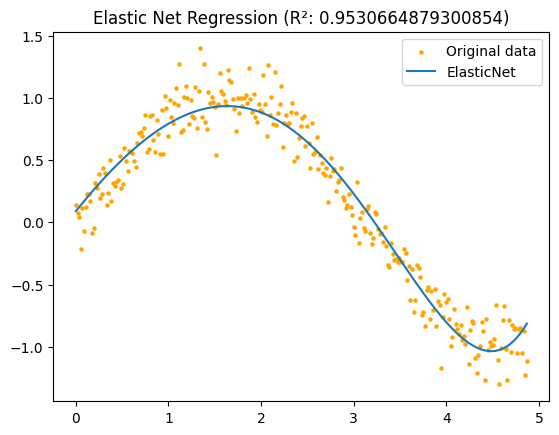

In [47]:
plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], en.predict(L2Normalizer(X)), label="ElasticNet")
plt.title('Elastic Net Regression (R²: {})'.format(en.score(L2Normalizer(X), y)));
plt.legend(loc="best")

# Unbalanced data and resampling


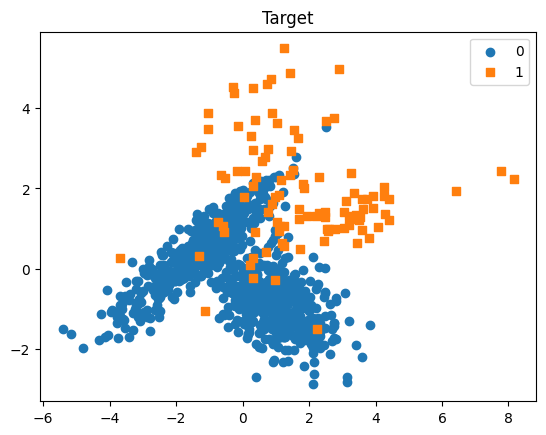

In [48]:
X, y = make_classification(
    n_classes=2, 
    class_sep=1.25, 
    weights=[.9, .1], 
    n_features=20, 
    n_samples=1000, 
    random_state=42
)

plot_classification(X, y)

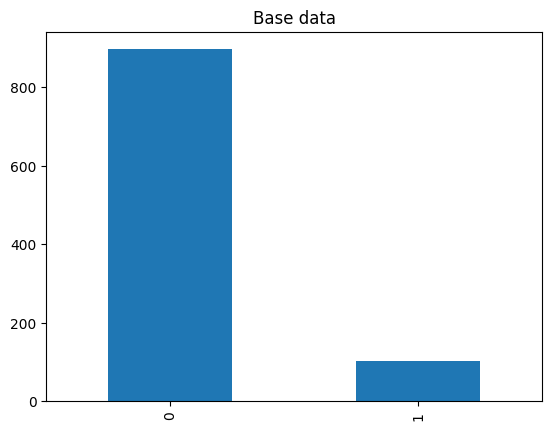

In [49]:
df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Base data');


## Random oversampling

Added 345 examples


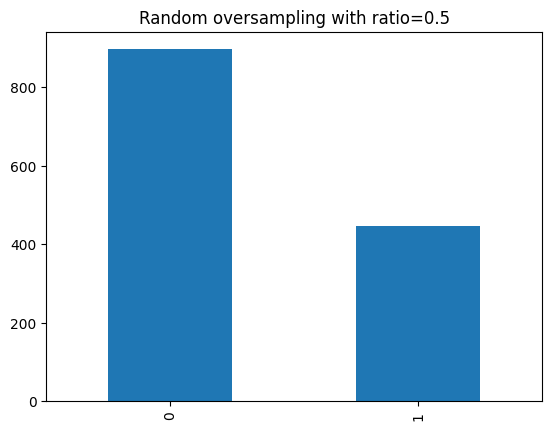

In [50]:
ros_sampler = RandomOverSampler(sampling_strategy=.5, random_state=42)
X_over, y_over = ros_sampler.fit_resample(X, y)

df = pd.DataFrame(X_over)
df['target'] = y_over
df.target.value_counts().plot(kind='bar', title='Random oversampling with ratio=0.5');

print(f'Added {len(y_over) - len(y)} examples')


## Oversampling - SMOTE

Added 345 examples


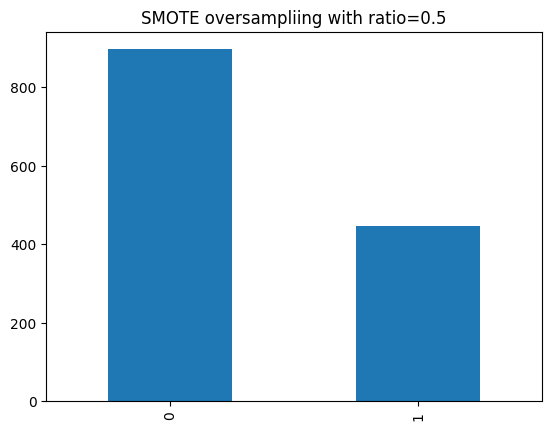

In [51]:
smote_sampler = SMOTE(sampling_strategy=0.5, random_state=42)
X_smote, y_smote = smote_sampler.fit_resample(X, y)

df = pd.DataFrame(X_smote)
df['target'] = y_smote
df.target.value_counts().plot(kind='bar', title='SMOTE oversampliing with ratio=0.5');

print(f'Added {len(y_smote) - len(y)} examples')


## Random undersampling

Removed 691 examples


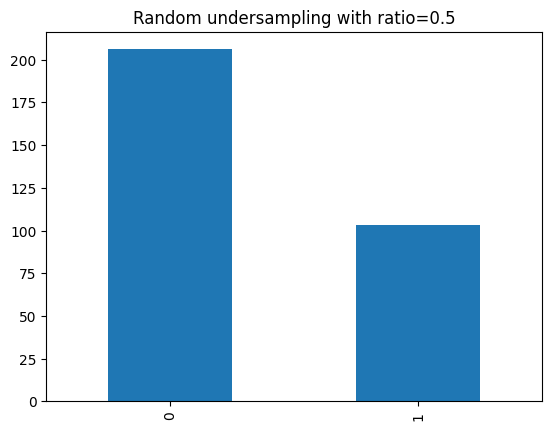

In [52]:
rus_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
X_under, y_under = rus_sampler.fit_resample(X, y)

df = pd.DataFrame(X_under)
df['target'] = y_under
df.target.value_counts().plot(kind='bar', title='Random undersampling with ratio=0.5');

print(f'Removed {len(y) - len(y_under)} examples')

## Undersampling - tomek links

Removed 7 examples


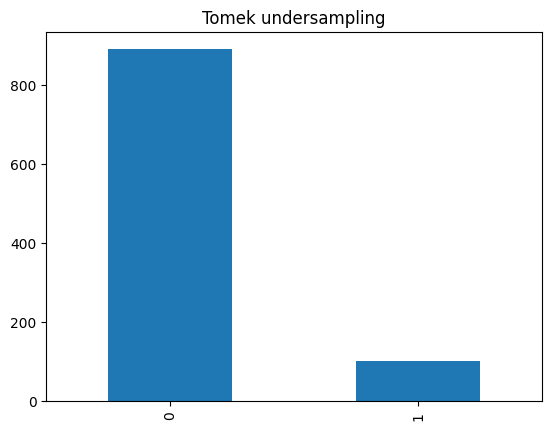

In [53]:
# TomekLinks
tomek_sampler = TomekLinks()
X_tomek, y_tomek = tomek_sampler.fit_resample(X, y)

df = pd.DataFrame(X_tomek)
df['target'] = y_tomek
df.target.value_counts().plot(kind='bar', title='Tomek undersampling');

print(f'Removed {len(y) - len(y_tomek)} examples')